<a href="https://colab.research.google.com/github/ChetHefton/4205_Group_Project/blob/main/loan_default_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#This cell imports necessary resources

import pandas as pd #data handling
import numpy as np #math and arrays

from sklearn.model_selection import train_test_split #split into train and validation
from sklearn.preprocessing import StandardScaler #normalizes
from sklearn.metrics import ( #import various metrics
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
)

from sklearn.linear_model import LogisticRegression #baseline model
from sklearn.tree import DecisionTreeClassifier #use for comparison
#advance model 1 & 2 vvv
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt #visualize
import seaborn as sns #more visualize

In [4]:
#This cell loads the dataset

#download the dataset files directly from our git repo
!wget -O cs-training.csv https://raw.githubusercontent.com/ChetHefton/ML-Loan-Default-Predicter/main/cs-training.csv
!wget -O cs-test.csv https://raw.githubusercontent.com/ChetHefton/ML-Loan-Default-Predicter/main/cs-test.csv

#load into pandas
train = pd.read_csv("cs-training.csv")
test = pd.read_csv("cs-test.csv")

#show first 5 rows to confirm it's loaded correctly
train.head()



--2026-02-17 06:40:34--  https://raw.githubusercontent.com/ChetHefton/ML-Loan-Default-Predicter/main/cs-training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7414964 (7.1M) [text/plain]
Saving to: ‘cs-training.csv’

cs-training.csv     100%[===================>]   7.07M  26.8MB/s    in 0.3s    

2026-02-17 06:40:35 (26.8 MB/s) - ‘cs-training.csv’ saved [7414964/7414964]

--2026-02-17 06:40:35--  https://raw.githubusercontent.com/ChetHefton/ML-Loan-Default-Predicter/main/cs-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
#This cell is basic dataset info

print("Shape of training data:", train.shape)
print("\nColumn names:")
print(train.columns)

#quick preview
train.head()


Shape of training data: (150000, 12)

Column names:
Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


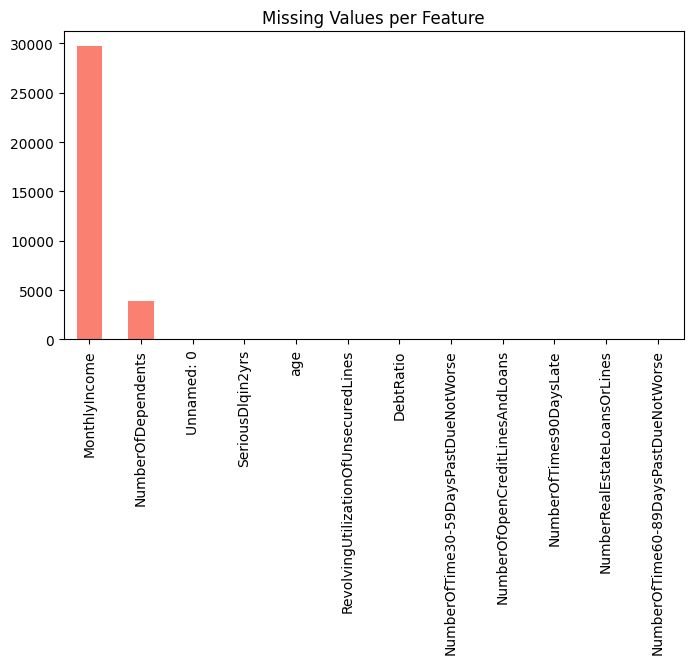

In [6]:
#This cell finds missing values in each column, otherwise the model will break

missing = train.isnull().sum().sort_values(ascending=False)

missing
plt.figure(figsize=(8,4))
missing.plot(kind='bar', color='salmon')
plt.title("Missing Values per Feature")
plt.show()


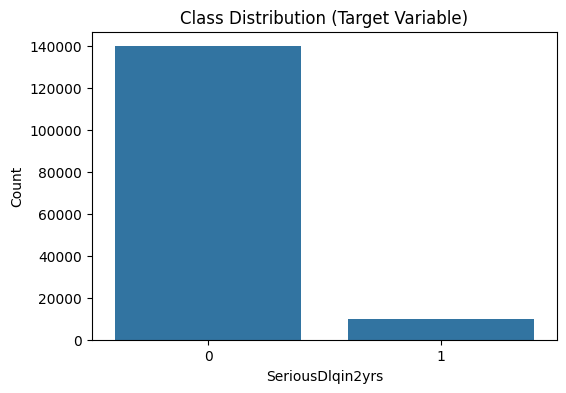

,count
SeriousDlqin2yrs,
0,139974
1,10026


In [7]:
#This cell checks class imbalance using the delinquency feature

plt.figure(figsize=(6,4))
sns.countplot(x=train['SeriousDlqin2yrs'])
plt.title("Class Distribution (Target Variable)")
plt.xlabel("SeriousDlqin2yrs")
plt.ylabel("Count")
plt.show()

#print actual counts
train['SeriousDlqin2yrs'].value_counts()


In [8]:
#This cell shows mean, std, min, max and quartiles to detect outliers

train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


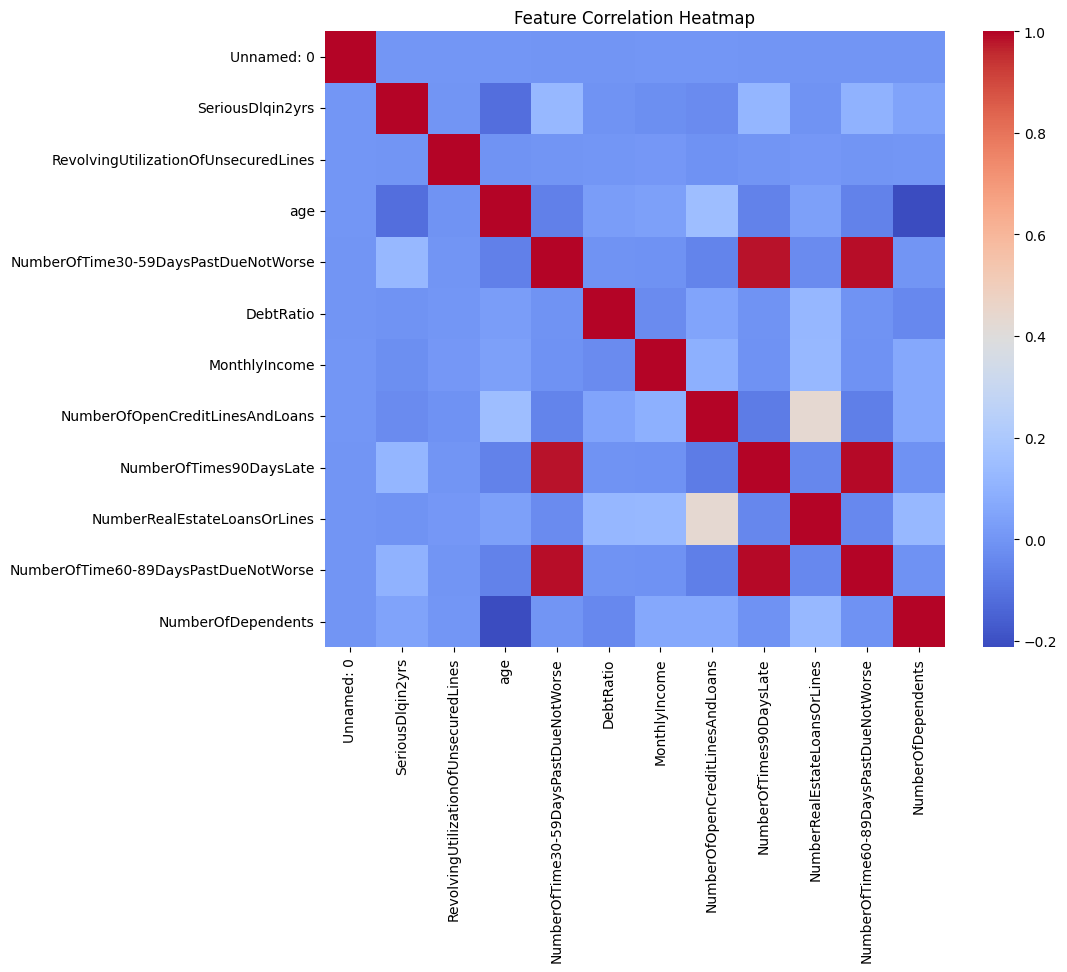

In [9]:
#This cell displays a heatmap of the numerical features

plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


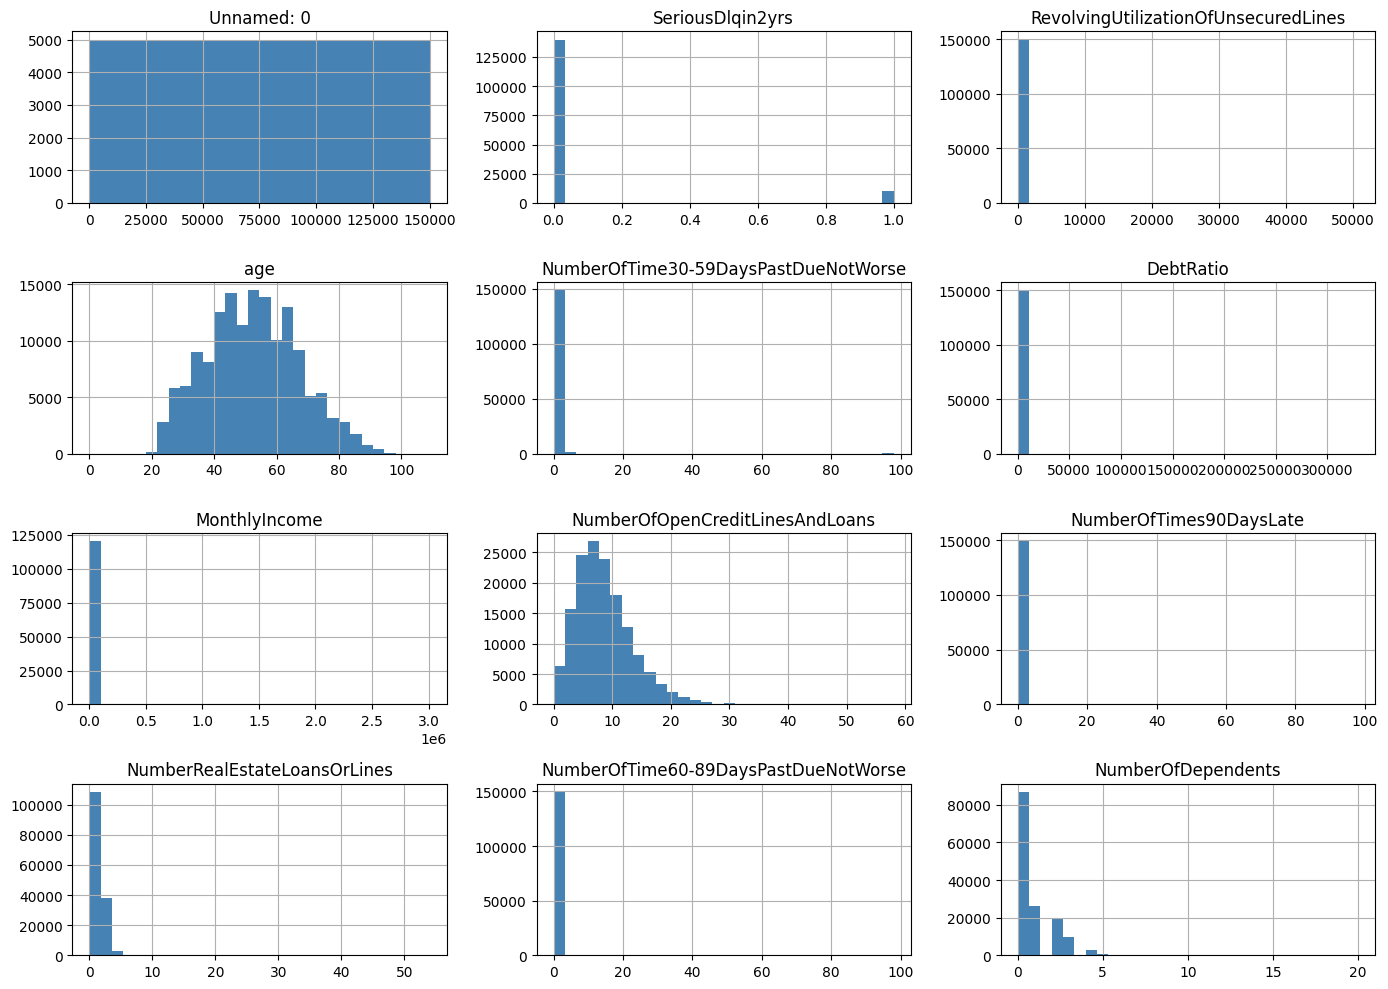

In [10]:
#This cell shows the dist of numeric features using histogram

train.hist(figsize=(14,10), bins=30, color='steelblue')
plt.tight_layout()
plt.show()


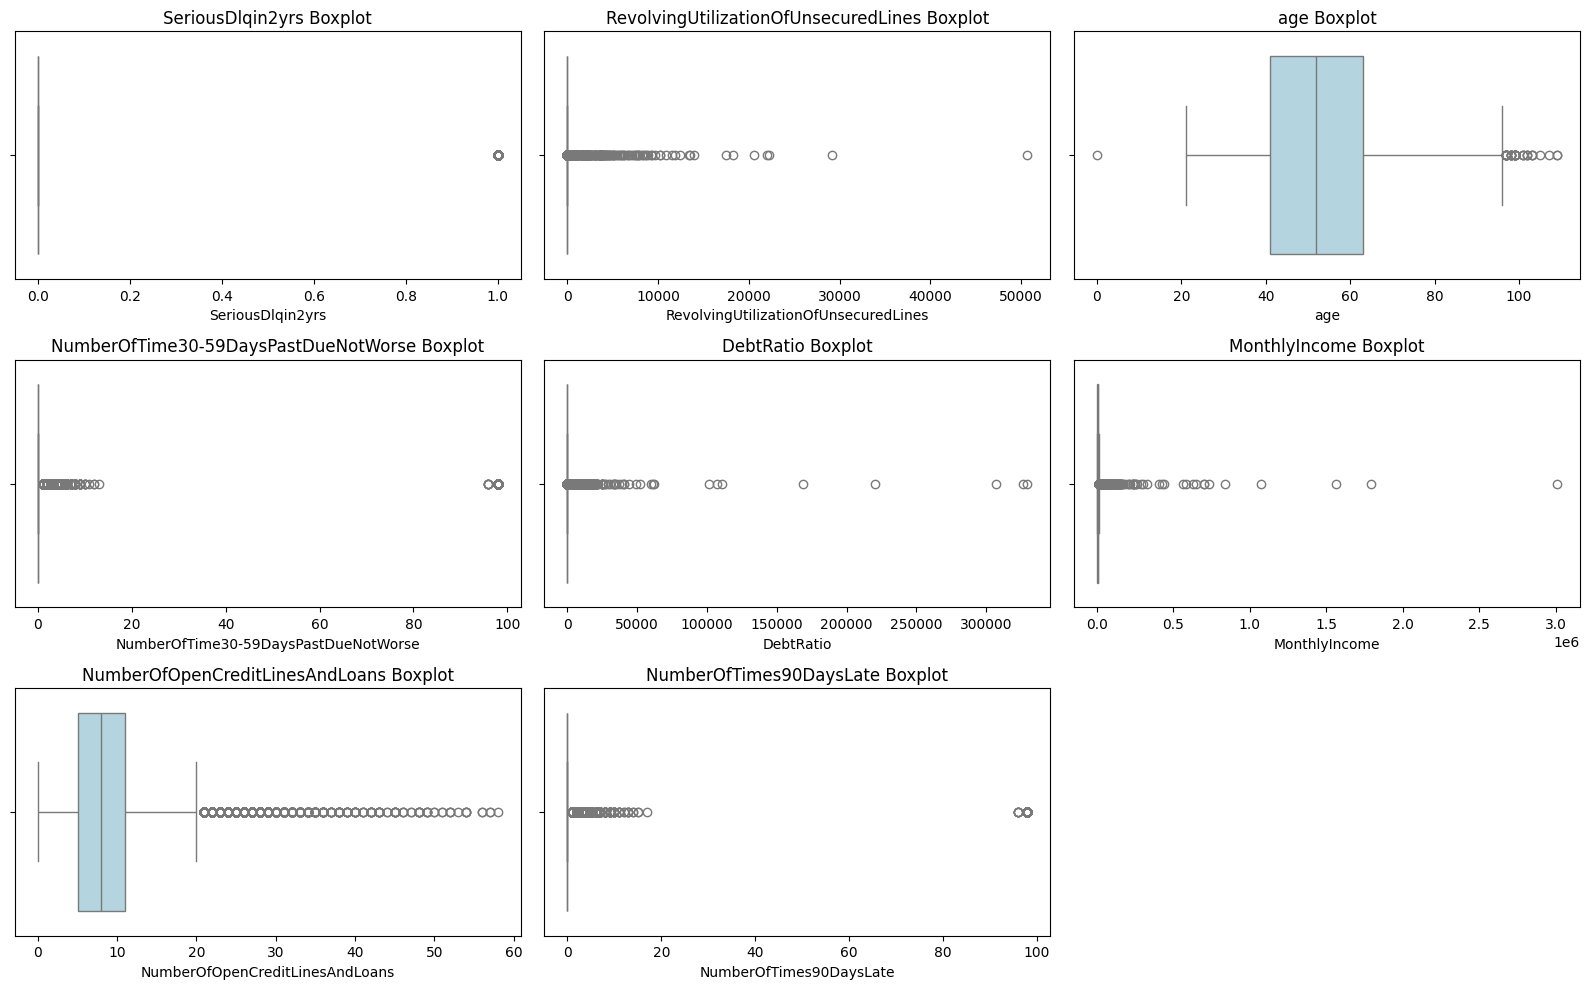

In [11]:
#This cell visualizes outliers

plt.figure(figsize=(16,10))

for i, col in enumerate(train.columns[1:9], 1):  #skip target + unnamed index
    plt.subplot(3,3,i)
    sns.boxplot(x=train[col], color='lightblue')
    plt.title(f"{col} Boxplot")

plt.tight_layout()
plt.show()


In [12]:
#This cell is preprocessing for the baseline model

#drop unnecessary column
if "Unnamed: 0" in train.columns:
    train = train.drop("Unnamed: 0", axis=1)

#fill missing values with median
train['MonthlyIncome'] = train['MonthlyIncome'].fillna(train['MonthlyIncome'].median())
train['NumberOfDependents'] = train['NumberOfDependents'].fillna(train['NumberOfDependents'].median())

#clip outliers at 1st and 99th percentile
for col in train.columns:
    if col != 'SeriousDlqin2yrs':
        low = train[col].quantile(0.01)
        high = train[col].quantile(0.99)
        train[col] = np.clip(train[col], low, high)

#split into features and target
X = train.drop('SeriousDlqin2yrs', axis=1)
y = train['SeriousDlqin2yrs']

#train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [13]:
#This cell is the baseline model, logistic regression

log_reg = LogisticRegression(max_iter=2000)

#train using scaled data
log_reg.fit(X_train_scaled, y_train)

#predictions
pred_lr = log_reg.predict(X_val_scaled)
prob_lr = log_reg.predict_proba(X_val_scaled)[:, 1]  #probability of default

#evaluation
print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_val, pred_lr))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, pred_lr))

print("\nClassification Report:")
print(classification_report(y_val, pred_lr))

print("AUC:", roc_auc_score(y_val, prob_lr))


Logistic Regression Performance
Accuracy: 0.9376

Confusion Matrix:
[[27766   229]
 [ 1643   362]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.61      0.18      0.28      2005

    accuracy                           0.94     30000
   macro avg       0.78      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000

AUC: 0.8578099224166768


In [15]:
#This cell is the 1st advanced model, Random Forest, more tuned towards f1 and recall

rf = RandomForestClassifier(
    n_estimators=300, #150 = ~45 sec, 300 = ~90sec and nearly maxes accuracy
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',   #helps with imbalance
    random_state=42
)

rf.fit(X_train, y_train)  #random forest doesn't need scaling

pred_rf = rf.predict(X_val)
prob_rf = rf.predict_proba(X_val)[:, 1]

print("Random Forest Performance")
print("Accuracy:", accuracy_score(y_val, pred_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, pred_rf))

print("\nClassification Report:")
print(classification_report(y_val, pred_rf))

print("AUC:", roc_auc_score(y_val, prob_rf))


Random Forest Performance
Accuracy: 0.9322

Confusion Matrix:
[[27332   663]
 [ 1371   634]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     27995
           1       0.49      0.32      0.38      2005

    accuracy                           0.93     30000
   macro avg       0.72      0.65      0.67     30000
weighted avg       0.92      0.93      0.93     30000

AUC: 0.8528124945717507


In [16]:
#this cell is the 2nd advanced model, gradient boosting

gb = GradientBoostingClassifier(
    n_estimators=200,    #number of boosting stages
    learning_rate=0.05, #step size for each stage
    max_depth=3,        #depth of individual trees
    subsample=0.8,      #use 80% of data per stage, stochastic boosting
    random_state=42
)

#no scaling required, use X_train/X_val
gb.fit(X_train, y_train)

pred_gb = gb.predict(X_val)
prob_gb = gb.predict_proba(X_val)[:, 1]

print("Gradient Boosting Performance")
print("Accuracy:", accuracy_score(y_val, pred_gb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, pred_gb))

print("\nClassification Report:")
print(classification_report(y_val, pred_gb))

print("AUC:", roc_auc_score(y_val, prob_gb))

Gradient Boosting Performance
Accuracy: 0.938

Confusion Matrix:
[[27727   268]
 [ 1592   413]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27995
           1       0.61      0.21      0.31      2005

    accuracy                           0.94     30000
   macro avg       0.78      0.60      0.64     30000
weighted avg       0.92      0.94      0.92     30000

AUC: 0.8680285979104747


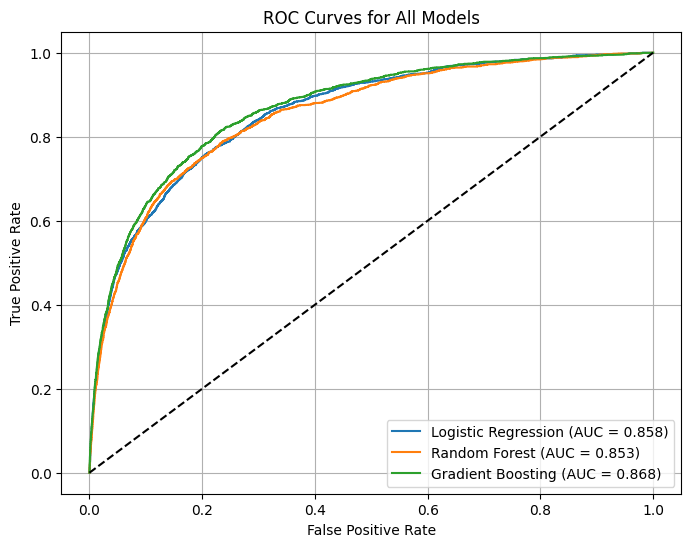

In [17]:
#This cell handles the ROC curves for all 3 models

plt.figure(figsize=(8,6))
#LR
fpr_lr, tpr_lr, _ = roc_curve(y_val, prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_val, prob_lr):.3f})")

#RF
fpr_rf, tpr_rf, _ = roc_curve(y_val, prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_val, prob_rf):.3f})")

#GB
fpr_gb, tpr_gb, _ = roc_curve(y_val, prob_gb)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {roc_auc_score(y_val, prob_gb):.3f})")

#plot it
plt.plot([0,1], [0,1], 'k--') #diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
#This cell builds the comparison table

results = []
#LR
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_val, pred_lr),
    "Precision (Class 1)": classification_report(y_val, pred_lr, output_dict=True)['1']['precision'],
    "Recall (Class 1)": classification_report(y_val, pred_lr, output_dict=True)['1']['recall'],
    "F1 (Class 1)": classification_report(y_val, pred_lr, output_dict=True)['1']['f1-score'],
    "AUC": roc_auc_score(y_val, prob_lr)
})
#RF
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_val, pred_rf),
    "Precision (Class 1)": classification_report(y_val, pred_rf, output_dict=True)['1']['precision'],
    "Recall (Class 1)": classification_report(y_val, pred_rf, output_dict=True)['1']['recall'],
    "F1 (Class 1)": classification_report(y_val, pred_rf, output_dict=True)['1']['f1-score'],
    "AUC": roc_auc_score(y_val, prob_rf)
})
#GB
results.append({
    "Model": "Gradient Boosting",
    "Accuracy": accuracy_score(y_val, pred_gb),
    "Precision (Class 1)": classification_report(y_val, pred_gb, output_dict=True)['1']['precision'],
    "Recall (Class 1)": classification_report(y_val, pred_gb, output_dict=True)['1']['recall'],
    "F1 (Class 1)": classification_report(y_val, pred_gb, output_dict=True)['1']['f1-score'],
    "AUC": roc_auc_score(y_val, prob_gb)
})
results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1 (Class 1),AUC
0,Logistic Regression,0.9376,0.612521,0.180549,0.278891,0.857810
1,Random Forest,0.9322,0.488820,0.316209,0.384010,0.852812
2,Gradient Boosting,0.9380,0.606461,0.205985,0.307520,0.868029


In [19]:
#This cell generates predictions on test set gradient boosting

#start from a fresh copy of test
test_proc = test.copy()

#drop the unnecessary index column
if "Unnamed: 0" in test_proc.columns:
    test_proc = test_proc.drop("Unnamed: 0", axis=1)

#fill missing values using the same strategy as training
test_proc['MonthlyIncome'] = test_proc['MonthlyIncome'].fillna(train['MonthlyIncome'].median())
test_proc['NumberOfDependents'] = test_proc['NumberOfDependents'].fillna(train['NumberOfDependents'].median())

#clip outliers using quantiles from the training data
for col in test_proc.columns:
    #test set has no target, so loop over all its columns
    low = train[col].quantile(0.01)
    high = train[col].quantile(0.99)
    test_proc[col] = np.clip(test_proc[col], low, high)

#make sure columns are in the same order as X_train
test_proc = test_proc[X_train.columns]

#predict probabilities with the best model, GB
test_pred_prob = gb.predict_proba(test_proc)[:, 1]  #probability of default

#build submission DataFrame for csv
submission = pd.DataFrame({
    "Id": test_proc.index,
    "ProbabilityOfDefault": test_pred_prob
})

#save to csv, for report
submission.to_csv("test_predictions.csv", index=False)

submission.head() #show preview

,Id,ProbabilityOfDefault
0,0,0.067253
1,1,0.074784
2,2,0.012817
3,3,0.068281
4,4,0.095825


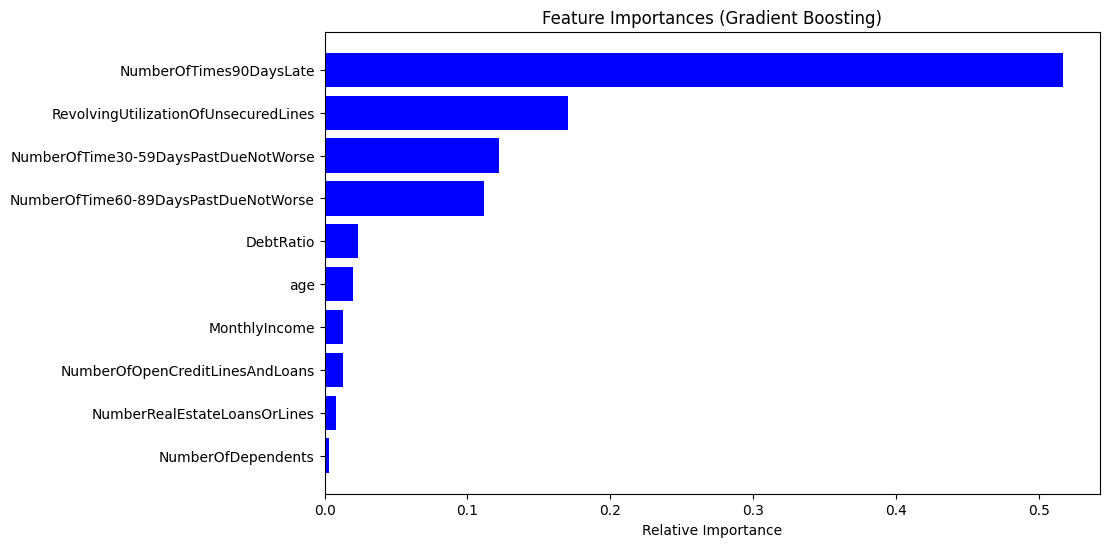

In [20]:
#visualize feature importance for gradient boosting
features = X.columns
importances = gb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances (Gradient Boosting)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()